Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image

In [ ]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

print (dist)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('reportPict/undist_calibration1.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

Line detection Pipeline
===

### Functions needed to detect lines in video

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib qt
%matplotlib inline


def convertToBinMix(img, yellowH=(20, 30), yellowS=(40, 255), whiteL=(205,255), sxThresh=(10, 255), lxThresh=(40, 255), dirThreshold=(0.8, 1.1)):
    """
    This functions returns binary image where lines are marked with '1' 
    
    Parameters
    ----------
    img : array
        Input BGR image
    yellowH : tuple
        threshold for yellow Hue channel
    yellowS : tuple
        threshold for yellow Saturation channel   
    whiteL : tuple
        threshold for white light channel  
    sxThresh : tuple
        threshold for X sobel over saturation channel
    sxThresh : tuple
        threshold for X sobel over light channel  
    dirThreshold
        threshold for sobel direction over light and saturation channel 
    Returns
    -------
    float
        Calculated radius
    """ 
    
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    hChannel = hls[:,:,0]
    lChannel = hls[:,:,1]
    sChannel = hls[:,:,2]
    
    # Sobel x over l channel
    sobelx = cv2.Sobel(lChannel, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(lChannel, cv2.CV_64F, 0, 1) # Take the derivative in y
    
    direction = np.arctan2(np.absolute(sobely), np.absolute(sobelx))# Calculate the direction of the gradient in radians
    
    absSobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaledSobel = np.uint8(255*absSobelx/np.max(absSobelx))
    
    # Threshold x gradient
    lxBinary = np.zeros_like(scaledSobel)
    lxBinary[(scaledSobel >= lxThresh[0]) & (scaledSobel <= lxThresh[1]) & (direction >= dirThreshold[0]) & (direction <= dirThreshold[1])] = 1    
 
    # Sobel x over s channel
    sobelx = cv2.Sobel(sChannel, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(sChannel, cv2.CV_64F, 0, 1) # Take the derivative in y
    direction = np.arctan2(np.absolute(sobely), np.absolute(sobelx))# Calculate the direction of the gradient in radians
    absSobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaledSobel = np.uint8(255*absSobelx/np.max(absSobelx))
    # Threshold x gradient
    sxBinary = np.zeros_like(scaledSobel)
    sxBinary[(scaledSobel >= sxThresh[0]) & (scaledSobel <= sxThresh[1]) & (direction >= dirThreshold[0]) & (direction <= dirThreshold[1])] = 1   


    # Threshold yellow pixels
    yellowBinary = np.zeros_like(hChannel)
    yellowBinary[(hChannel >= yellowH[0]) & (hChannel <= yellowH[1]) & (sChannel >= yellowS[0]) & (sChannel <= yellowS[1])] = 1
    
    # threshold white pixels
    whiteBinary = np.zeros_like(lChannel)
    whiteBinary[(lChannel >= whiteL[0]) & (lChannel <= whiteL[1])] = 1
    # Stack each channel 
    resultBin = np.zeros_like(whiteBinary)
    resultBin[(yellowBinary == 1) | (whiteBinary == 1) | (lxBinary == 1) | (sxBinary == 1)] = 1
    return resultBin


def convertToBinColors(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS).astype(np.float)
    #bgr thresholding for yellow
    lower = np.array([0,140,170],dtype = "uint8")
    upper = np.array([170, 255, 255],dtype = "uint8")
    bgrYellow = cv2.inRange(image, lower, upper)

    #bgr thresholding for white
    lower = np.array([200,100,100],dtype = "uint8")
    upper = np.array([255, 255, 255],dtype = "uint8")
    bgrWhite = cv2.inRange(image, lower, upper)

    #hls thresholding for yellow
    lower = np.array([15,90,40],dtype = "uint8")
    upper = np.array([30, 255, 255],dtype = "uint8")
    hlsYellow = cv2.inRange(hls, lower, upper)
    
    binary = np.zeros_like(hlsYellow)
    binary [(hlsYellow == 255) | (bgrYellow==255) | (bgrWhite==255)]= 1
    return binary

def convertToBinNotGray(image):  
    #difference between chnnels is small for gray
    b = image[:,:,0].astype('int16')
    g = image[:,:,1].astype('int16')
    r = image[:,:,2].astype('int16')
    bMinG = abs(b-g).astype('uint8')
    bMinR = abs(b-r).astype('uint8')
    gMinR = abs(g-r).astype('uint8')
    diff=20
    diffGray = np.zeros_like(bMinG)
    #diffGray[(bMinG <= diff) & (bMinR <= diff) & (gMinR <= diff)] = 1 #challenge
    diffGray[(bMinG <= diff)  & (gMinR <= diff)] = 1
    #bgr thresholding for gray
    lower = np.array([0,0,0],dtype = "uint8")
    upper = np.array([185, 185, 185],dtype = "uint8")
    maybeBgrGray = cv2.inRange(image, lower, upper)
    upper = np.array([120, 120, 120],dtype = "uint8")
    alwaysBgrGray = cv2.inRange(image, lower, upper)
    
    #hls thresholding for gray
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    lower = np.array([8,0,0],dtype = "uint8")
    upper = np.array([18, 200, 90],dtype = "uint8")
    hlsGray = cv2.inRange(hls, lower, upper)
    binary = np.zeros_like(diffGray)
    binary [((maybeBgrGray == 0) | (diffGray==0)) & (alwaysBgrGray == 0) & (hlsGray==0)]= 1
    #binary [((maybeBgrGray == 0) | (diffGray==0)) & (alwaysBgrGray == 0)]= 1
    #binary [diffGray == 0]= 1
    return binary


ymPerPix = 3.0/(358.0-462.0) # based on dashed line measured on bird eye view and real life line legth of 3m
xmPerPix = 3.7/(978.0-302.0) # based on line width measured on bird eye view and real life line width of 3.7m
# polyCoef - Coeficients of polymial of left line in pixel space
# yEval - where radius should be calculated in y pixels
def calculateRadius(polyCoef, yEval):
    """
    calculate radius of quadratic function
    
    Parameters
    ----------
    polyCoef : array
        Coeeficients of quadratic poly fit 
    yEval : float
        Argument for which radius is calculated
    Returns
    -------
    float
        Calculated radius
    """ 
    #x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+c
    polyCoefMeters = np.array([polyCoef[0]*(xmPerPix/(ymPerPix**2)), polyCoef[1]*(xmPerPix/ymPerPix), polyCoef[2]])
    # Calculate the radius of curvature
    #Rcurve=((1+(2Ay+B)^2)^3/2)/∣2A∣
    radius = ((1 + (2*polyCoefMeters[0]*yEval*ymPerPix + polyCoefMeters[1])**2)**1.5) / np.absolute(2*polyCoefMeters[0])
    return radius
                         
 
def squarefit(pixX, pixY):
    """
    Fit a second order polynomial
    
    Parameters
    ----------
    pixX : array
        X coordinates of pixels to be fitted
    pixY : array
        Y coordinates of pixels to be fitted
    Returns
    -------
    array
        Coeeficients of quadratic poly fit 
    """ 
    if pixX.size == 0 or pixY.size == 0:
        return None
    # Fit a second order polynomial
    return np.polyfit(pixY, pixX, 2)

def calcQuadFitVal(squareFit, arg):
    """
    calculate quadratic function value
    
    Parameters
    ----------
    squareFit : array
        Coeeficients of quadratic poly fit 
    arg : float
        Argument for which value is calculated
    Returns
    -------
    float
        Value for given argument
    """ 
    return squareFit[0]*arg**2 + squareFit[1]*arg + squareFit[2]


def pixelsSanityCheck(pixY, minpixels, imgShape):
    """
    Perform sanity checks on line pixels
    
    Parameters
    ----------
    pixY : array
        Y coordinates of line pixels
    minpixels : int
        Minimum number of pixels
    imgShape: array
        shape of image
    Returns
    -------
    bool
        True if check was successful False otherwise
    """ 
    middleY = int(imgShape[0]/2)
    if len(pixY) < minpixels or np.amax(pixY) < middleY or np.amin(pixY) > middleY:
        return False 
    return True

def lineFitSanitycheck(leftFit, rightFit, margin, imgShape):
    """
    Perform sanity checks on fitted lines
    
    Parameters
    ----------
    leftFit : array
        Coeeficients of left line quadratic poly fit 
    rightFit : array
        Coeeficients of right line quadratic poly fit
    margin : integer
        margin detected line width
    imgShape: array
        shape of image
    Returns
    -------
    bool
        True if check was successful False otherwise
    """ 
    bottomY = imgShape[0]
    imageHalf = int(imgShape[1]/2)
    bottomRight = calcQuadFitVal(rightFit, bottomY)
    bottomLeft = calcQuadFitVal(leftFit, bottomY)
    #check if lines are on correct sides
    if bottomLeft > imageHalf or bottomRight < imageHalf:
        return False
    bottomWidth = bottomRight - bottomLeft
    #check if line is wide enougth
    if bottomWidth < (imageHalf - margin):
        return False
    #check if line width does not warry more than margin
    for y in range(bottomY-1):
        widthDiff = abs((calcQuadFitVal(rightFit, y) - calcQuadFitVal(leftFit, y)) - bottomWidth)
        if widthDiff > margin:
            return False
    return True


def markLines(img, undistImg, prevLeftFit = None, prevRightFit = None, margin = 100, minpix = 50, nwindows = 9):
    """
    This functions detect lines, calculate curvature and car position using binary bird eye image and marks them on BGR image
    
    Parameters
    ----------
    img : array
        input bird eye view binary image
    undistImg : array
        input undistorted image on which lines and curvatures will be marked
    prevLeftFit : array
        Coeeficients of lefy line quadratic poly fit in previous frame 
    prevRightFit : array
        Coeeficients of right line quadratic poly fit in previous frame 
    margin : integer
        search margin for new line
    minpix: integer
        minimum number of pixel in one window to detect the line
    nwindows: integer
        Number of sliding windows used to search each line
    Returns
    -------
    array
        Debug bird eye view image with right and left line marked
    array
        BGR image with marked lines, debug image in up left corner, radius and car possition printed in up right corner
    array
        Coeeficients of left line quadratic poly fit 
    array
        Coeeficients of right line quadratic poly fit 
    """
    #initialize variables used later in the code
    offCenter = None
    finalRadius =None
    leftFit = None
    rightFit = None
    outputImg = undistImg.copy()
    leftFit = [0,0,0]
    rightFit = [0,0,0]
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    debugImg = np.uint8(np.dstack((img, img, img))*255)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # try to find lines usign previus fit 
    if prevLeftFit != None and prevRightFit != None:
        left_lane_inds = ((nonzerox > calcQuadFitVal(prevLeftFit, nonzeroy) - margin) & 
                          (nonzerox < calcQuadFitVal(prevLeftFit, nonzeroy) + margin)) 

        right_lane_inds = ((nonzerox > calcQuadFitVal(prevRightFit, nonzeroy) - margin) &
                           (nonzerox < calcQuadFitVal(prevRightFit, nonzeroy) + margin))
        
        lPixX = nonzerox[left_lane_inds]
        lPixY = nonzeroy[left_lane_inds]
        rPixX = nonzerox[right_lane_inds]
        rPixY = nonzeroy[right_lane_inds]
        if pixelsSanityCheck(rPixY, minpix, img.shape) and pixelsSanityCheck(lPixY, minpix, img.shape):
            leftFit = squarefit(lPixX, lPixY)
            rightFit = squarefit(rPixX, rPixY)
        if rightFit == None or leftFit == None or lineFitSanitycheck(leftFit, rightFit, margin, img.shape) == False:
            left_lane_inds = []
            right_lane_inds = []
            leftFit = None
            rightFit = None
    #check if both lines were found where were expected if not execute full search
    if len(right_lane_inds) < nwindows*minpix or len(right_lane_inds) < nwindows*minpix:
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image


            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                left_lane_inds.append(good_left_inds)
                # Append only when line is detected
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                cv2.rectangle(debugImg,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                (0,255,0), 4)

            if len(good_right_inds) > minpix: 
                right_lane_inds.append(good_right_inds)
                # Append only when line is detected
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                cv2.rectangle(debugImg,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                (0,255,0), 4)
        if len(left_lane_inds) !=0 and len(right_lane_inds) !=0 :
            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            lPixX = nonzerox[left_lane_inds]
            lPixY = nonzeroy[left_lane_inds]
            rPixX = nonzerox[right_lane_inds]
            rPixY = nonzeroy[right_lane_inds]
            if pixelsSanityCheck(rPixY, minpix, img.shape) and pixelsSanityCheck(lPixY, minpix, img.shape):
                leftFit = squarefit(lPixX, lPixY)
                rightFit = squarefit(rPixX, rPixY)

    #if sanity check still fails use line detected in previous frame
    if rightFit == None or leftFit == None or lineFitSanitycheck(leftFit, rightFit, margin, img.shape) == False:
        leftFit = prevLeftFit
        rightFit= prevRightFit
    else:
        debugImg[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        debugImg[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if leftFit != None and rightFit != None:
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = calcQuadFitVal(leftFit, ploty)
        right_fitx = calcQuadFitVal(rightFit, ploty)

        cv2.polylines(debugImg, np.int_(np.dstack((left_fitx, ploty))), False, (255,255, 0),5)
        cv2.polylines(debugImg, np.int_(np.dstack((right_fitx, ploty))), False, (255,255, 0),5)
        Munwrap = cv2.getPerspectiveTransform(dst, src)
        #select lines by color
        lineMask = cv2.inRange(debugImg, np.array([255,255,0]), np.array([255,255,0]))
        img_size = (lineMask.shape[1], lineMask.shape[0])
        maskUnwraped = cv2.warpPerspective(lineMask, Munwrap, img_size , flags=cv2.INTER_LINEAR)
        outputImg[maskUnwraped.astype(bool)] = np.array([0,0,255]) #overlay markd lines

        #Calculate Radius for left and right fit and select one with more pixels
        leftRadius = calculateRadius(leftFit, debugImg.shape[0])
        rightRadius = calculateRadius(rightFit, debugImg.shape[0])
        if len(left_lane_inds) > len(right_lane_inds):
            finalRadius = leftRadius
        else:
            finalRadius = rightRadius
        #Calculate how far of center the car is
        offCenter = ((leftx_base + rightx_base) - debugImg.shape[1]) * xmPerPix
        
    #print('left', left_fit, 'right', right_fit)
    #print(leftRadius, 'm', rightRadius, 'm')  
    if offCenter != None and finalRadius != None:
        cv2.putText(outputImg, 'Radius: ' + str("{0:.1f}".format(finalRadius)) +'m', (670,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), thickness=2)
        cv2.putText(outputImg, 'Off Center: ' + str("{0:.1f}".format(offCenter)) +'m', (550,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), thickness=2)
    smallDebug = cv2.resize(debugImg, (0, 0), fx=0.4, fy=0.4)
    outputImg[20:20 + smallDebug.shape[0], 20:20 + smallDebug.shape[1], :] = smallDebug
    return debugImg, outputImg, leftFit, rightFit


prevLeftFit = None # Variable storing previously detected left line
prevRightFit = None  # Variable storing previously detected right line
src = np.float32([[580,460], [702,460], [233,700], [1075,700]]) # Source coordinates for bird eye view transformation
offset = 300
img_size = [1280, 720]
dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                 [offset, img_size[1]], 
                 [img_size[0]-offset, img_size[1]]])# Destination coordinates for bird eye view transformation
def processImageLines(image):
    """
    This functions detect lines, calculate curvature and car position on RGB image
    
    This function combine full pipeline detecting lines on RGB image

    Parameters
    ----------
    image : array
        Input RGB image to be converted.

    Returns
    -------
    array
        Image with detected lines, curvature radius and car possition overlaid.
    """
    global prevLeftFit
    global prevRightFit
    imageBGR = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #convert image to BGR because image pipeline accepts this format
    dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) ) # read distortion coeficinets calculated above
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    undistImg = cv2.undistort(imageBGR, mtx, dist, None, mtx)
    binImg = convertToBinNotGray(undistImg)
    img_size = (binImg.shape[1], binImg.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    wrapedImg = cv2.warpPerspective(binImg, M, img_size , flags=cv2.INTER_LINEAR)
    markedImg, undistImg, prevLeftFit, prevRightFit = markLines(wrapedImg, undistImg, prevLeftFit = prevLeftFit, prevRightFit = prevRightFit)
    return cv2.cvtColor(undistImg, cv2.COLOR_BGR2RGB) #Return RGB image

### Process project video

In [2]:
videoName = 'project_video.mp4'
vidOutput = 'output_videos/' + 'lines_' + videoName
clip1 = VideoFileClip(videoName)
prevLeftFit = None
prevRightFit = None
whiteClip = clip1.fl_image(processImageLines) 
%time whiteClip.write_videofile(vidOutput, audio=False)

[MoviePy] >>>> Building video output_videos/lines_project_video.mp4
[MoviePy] Writing video output_videos/lines_project_video.mp4


100%|███████████████████████████████████████████████████████████████████▉| 1260/1261 [02:21<00:00,  8.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lines_project_video.mp4 

Wall time: 2min 22s


### Play the  projec video

In [3]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vidOutput))

Vehicle detection Pipeline
===

### Feature extractions functions based or taken from lesson 20 used for vehicle detection

In [15]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9 scale features
    feat = np.concatenate(img_features)
    #scaler = StandardScaler().fit(feat)
    # Apply the scaler to file_features
    #feat = scaler.transform(feat)
    #10) return features
    return feat

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        feat = single_img_features(image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)  
        features.append(feat)
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_windows=[(64, 64)], xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the number of windows in x/y
    # Initialize a list to append window positions to
    window_list = []
    # Compute the number of pixels per step in x/y
    for xy_window in xy_windows:
        x_step = xy_window[0]*(1-xy_overlap[0])
        y_step = xy_window[1]*(1-xy_overlap[1])
        for y in range (int(y_start_stop[0]), int(y_start_stop[1])-xy_window[1] + 1, int(y_step)):
            for x in range(int(x_start_stop[0]), int(x_start_stop[1]) -xy_window[0] + 1, int(x_step)):
                window_list.append(((x,y),(x+xy_window[0] ,y+xy_window[1])))
    # Return the list of windows
    
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf,  train_img_size=(64,64), color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], train_img_size)      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = np.array(features).reshape(1, -1)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))


            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

### Train the classifier 

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Read in cars and notcars
notcars = glob.glob('non-vehicles/**/*.png', recursive=True)
cars = glob.glob('vehicles/**/*.png', recursive=True)

limit = 2000
cars = cars[0:limit]     
notcars = notcars[0:limit]
print('Number of vehicles:', len(cars), 'Number of non vehicles:', len(notcars))

### Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
#X_scaler_train = StandardScaler().fit(X_train)
# Apply the scaler to X
#X_train = X_scaler_train.transform(X_train)
#X_scaler_test = StandardScaler().fit(X_test)
#X_test = X_scaler_test.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

C:\Python36\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Number of vehicles: 2000 Number of non vehicles: 2000
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
0.62 Seconds to train SVC...
Test Accuracy of SVC =  0.9825


### Test clasifier with fixed window size

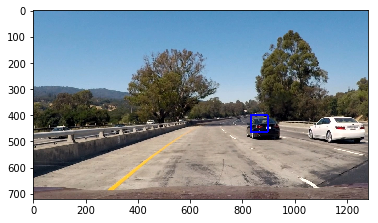

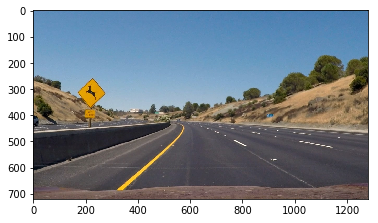

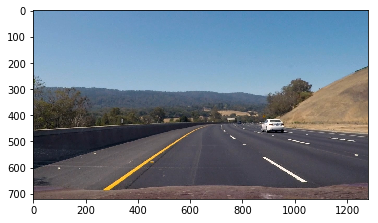

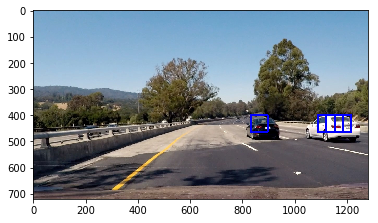

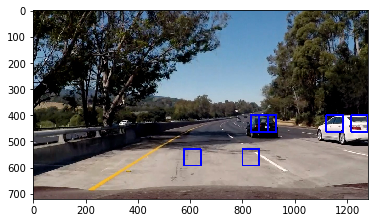

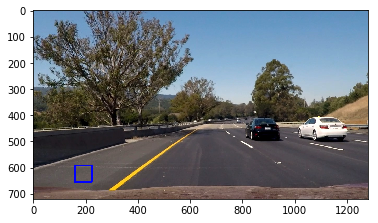

In [23]:
images = glob.glob('test_images/*.jpg')

for imageName in images:
    image = mpimg.imread(imageName)
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255# because input is jpg and train was png
    y_start_stop = [400, 680] # Min and max in y to search in slide_window()
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_windows=[(64, 64)], xy_overlap=(0.5, 0.5))
    hot_windows = search_windows(image, windows, svc, train_img_size=(64,64), color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    plt.figure()
    plt.imshow(window_img)

### Test clasifier with variable window size

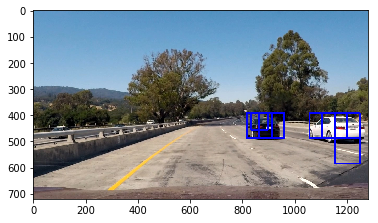

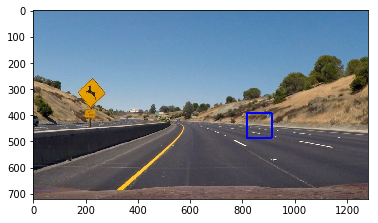

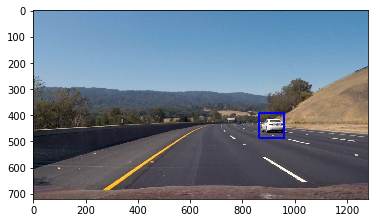

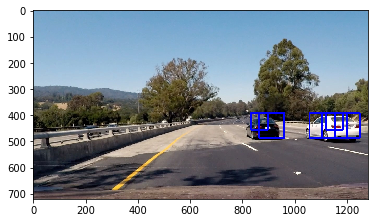

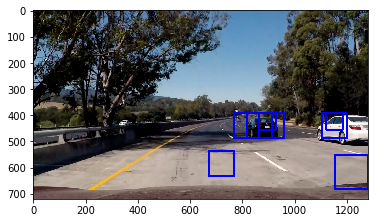

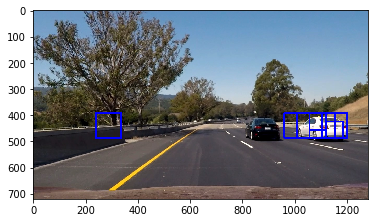

In [35]:
images = glob.glob('test_images/*.jpg')
hotWindowsList = []
markedImgsList =[]
for imageName in images:
    image = mpimg.imread(imageName)
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255 # because input is jpg and train was png
    y_start_stop = [392, 488] # smaller windows range
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_windows=[(64, 64),(96, 96)], xy_overlap=(0.5, 0.5))
    y_start_stop = [488, 680] # larger windows range
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_windows=[(96, 96),(128, 128)], xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, train_img_size=(64,64), color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    hotWindowsList.append(hot_windows)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    markedImgsList.append(window_img)
    plt.figure()
    plt.imshow(window_img)

### Create heat map

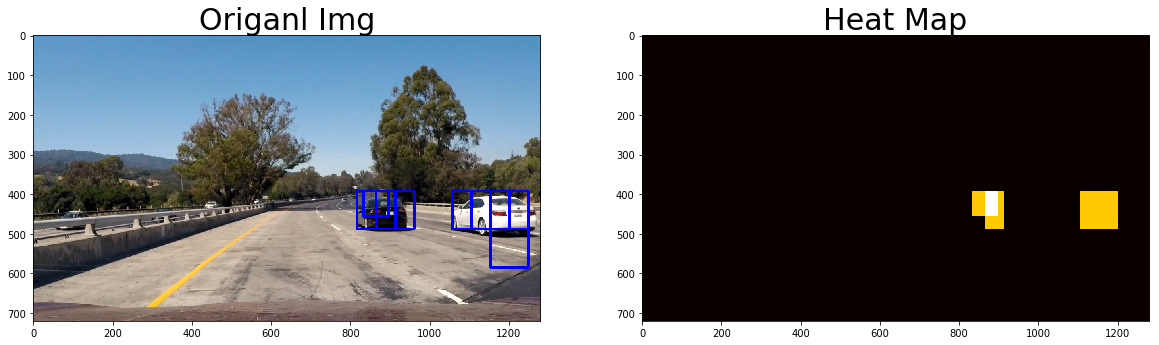

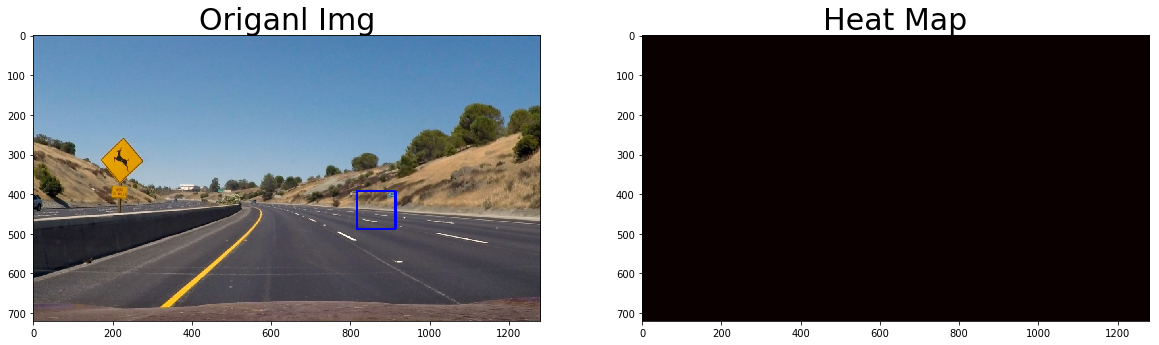

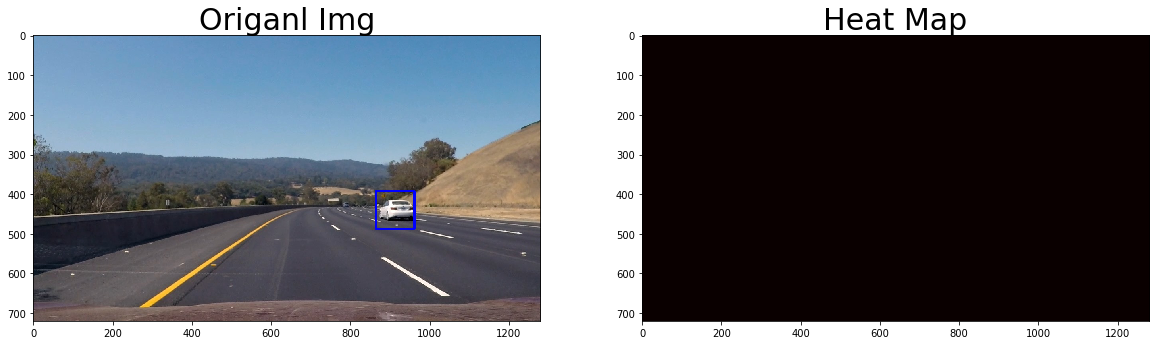

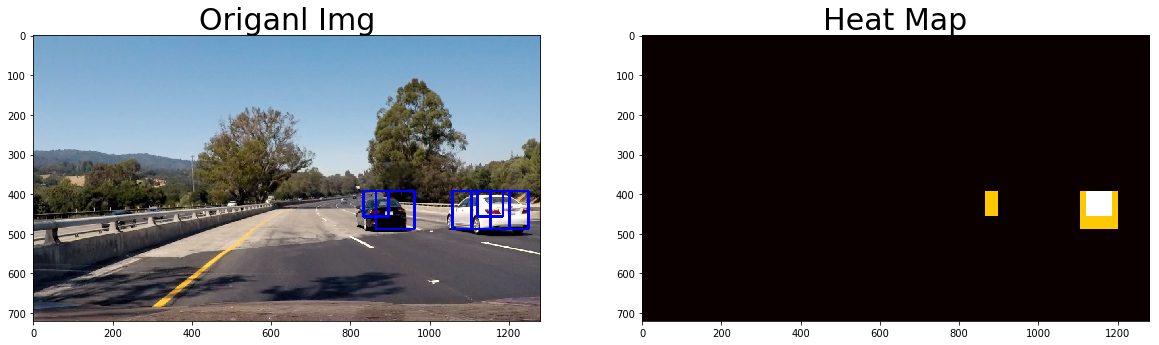

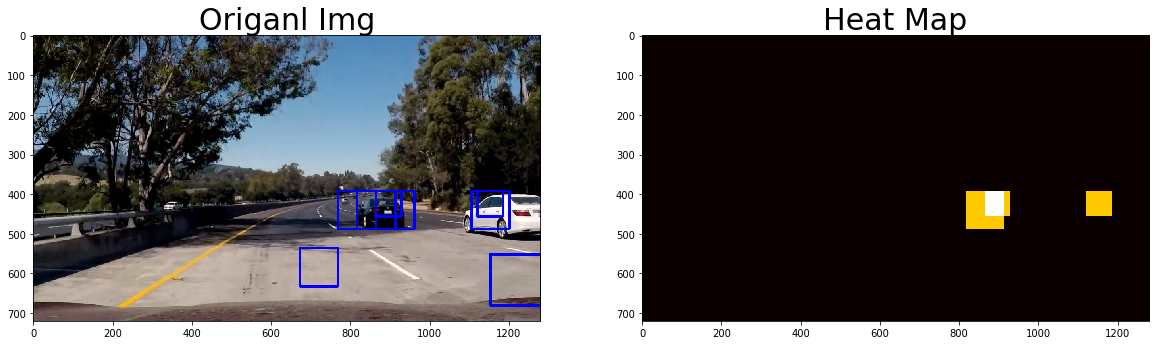

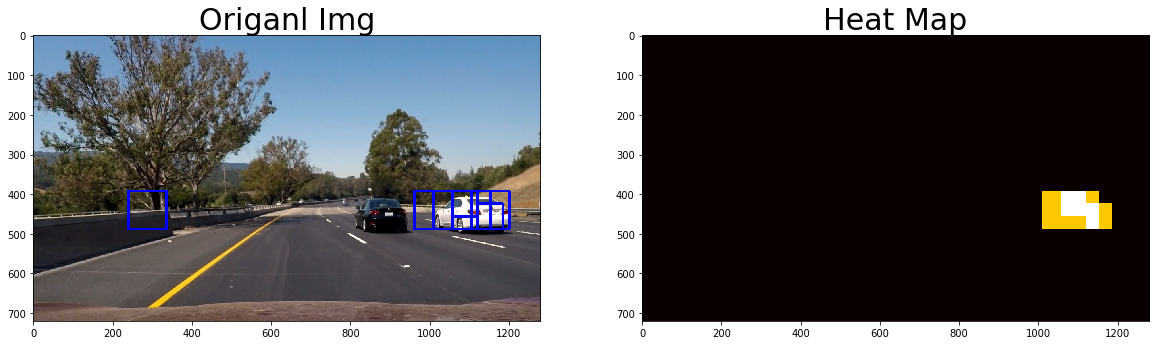

In [36]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

for markedImg, hotWindows in zip(markedImgsList, hotWindowsList):
    heat = np.zeros_like(markedImg[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hotWindows) 
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(markedImg)
    ax1.set_title('Origanl Img', fontsize=30)
    ax2.imshow(heatmap, cmap='hot')
    ax2.set_title('Heat Map', fontsize=30)